<a href="https://colab.research.google.com/github/Tecnologico-de-Monterrey-MNA/nlp-2023-Equipo-5/blob/main/Equipo05_semana05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

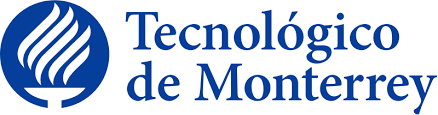

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad en Equipos - Semana 5: Modelos Embebidos Caso Amazon/Yelp/IMDb**

###**Equipo 5:**

###**A01748750 - Evelyn Aylin Rendón Medina**
###**A01002111 - Luis Salvador Cruz Najera**
###**A01169213 - Laura Elena Hernández Mata**
###**A01793052 - Juan Carlos Lopez Cruz**
###**A01793054 - Rafael José Mateo Comprés**

# Introducción:

**Algoritmos word embedding**

Los algoritmos word embedding nos permiten introducir la variabilidad y flexibilidad que no otorgan algoritmos como el de la similitud, dentro de la forma y los componentes del vector.

Estos algoritmos son mucho más complejos que los que hemos visto anteriormente. Entre ellos se encuentran:

* Glove.
* Word2vec.
* Fast2vec.
* **FastText**

**FastText**

FastText es un modelo de Gensim que sirve para realizar word embedding y clasificación. En él se crean algoritmos de aprendizaje supervisado y no supervisado que sirven para obtener representaciones vectoriales de palabras.

A diferencia de Word2Vec, que trabaja a nivel de palabra, FasText trata de capturar la información morfológica de las palabras.

De esta manera, una palabra quedará representada por sus n-gramas. El tamaño de los n-gramas deberá definirse como hiperparámetro:

* min_n: el valor mínimo de n a considerar.
* max_n: el valor máximo de n a considerar.

**Libreria fasText**

fastText es una biblioteca para el aprendizaje eficiente de las representaciones de palabras y la clasificación de oraciones.



#**Actividad en Equipos - Semana 5:** 


En la actividad de esta semana trabajarás en equipos con el modelo de vectores continuos/embebidos FastText, es decir, el modelo desarrollado por Facebook en 2016.

Una manera de trabajar con estos modelos pre-entrenados, es generando el vocabulario a partir de tu conjunto de datos de entrenamiento. Para cada palabra de tu vocabulario, podrás sustituirlo por su correspondiente vector continuo. En caso de que no exista el vector para una palabra en particular, se puede eliminar dicha palabra, o bien sustituirla por el vector continuo más cercano. En esta actividad deberás aplicar esta segunda opción. Existen diversas propuestas para utilizar dichos vectores continuos como entrada para modelos de aprendizaje automático. En particular, en esta actividad cada enunciado será sustituido por el vector promedio de todos los tokens que lo forman.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerías a Utilizar

In [ ]:
import pandas as pd  
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### 1. Descarga los 3 archivos de Canvas. En particular, el archivo de datos de IMDb ya no requiere transformarse para obtener sus 1000 registros. Al cargar los datos de los tres archivos deberás tener un DataFrame de Pandas de 3000 registros, con sus etiquetas. Los archivos los encuentras en Canvas y se llaman: amazon5.txt, imdb5.txt, yelp5.txt.

In [ ]:
dfa = pd.read_csv('https://raw.githubusercontent.com/luiscruzn/data/main/amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi = pd.read_csv('https://raw.githubusercontent.com/luiscruzn/data/main/imdb5.txt', sep='\s{3,}', names=['review','label'], header=None, encoding='utf-8')
dfy = pd.read_csv('https://raw.githubusercontent.com/luiscruzn/data/main/yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')


print('Total de registros de Amazon:',dfa.shape)
print('Total de registros de IMBD:',dfi.shape)
print('Total de registros de Yelp:',dfy.shape)

<ipython-input-3-e792789dce2c>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfi = pd.read_csv('https://raw.githubusercontent.com/luiscruzn/data/main/imdb5.txt', sep='\s{3,}', names=['review','label'], header=None, encoding='utf-8')


Total de registros de Amazon: (1000, 2)
Total de registros de IMBD: (1000, 2)
Total de registros de Yelp: (1000, 2)


In [ ]:
dfa.info()
dfi.info()
dfy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
dfi.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [ ]:
# Concatenamos los tres conjuntos para tener finalmente los 3000 registros:

df = pd.concat([dfa, dfi, dfy], ignore_index=True)   # Tienes que usar el "ignore_index", de lo contrario reincia cada 
                                                      # vez de 0 a 999 los índices.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
df['label'].value_counts()   # Recordemos que tenemos un 50% de comentarios positivos y de negativos.

0    1500
1    1500
Name: label, dtype: int64

In [ ]:
X = df.review     # Serie de strings
Y = df.label      # Serie de enteros 0s y 1s

doc = df.values.tolist() # Lista con los registros
doc[17:21]

[['So Far So Good!.', 1],
 ['Works great!.', 1],
 ['It clicks into place in a way that makes you wonder how long that mechanism would last.',
  0],
 ["I went on Motorola's website and followed all directions, but could not get it to pair again.",
  0]]

### 2. Realiza de nuevo un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización. Como aplicaremos modelos embebidos pre-entrenados, queremos palabras lo más cercanas a las existentes en un idioma, inglés en este caso. Aplica y justifica cualquier otro proceso de limpieza que consideres adecuado. Recuerda que en esta actividad se usarán vectores embebidos para un problema de clasificación, por lo que deberás tomar de acuerdo a este contexto. Justifica todas las transformaciones que se apliquen.

In [ ]:
nltk.download('punkt')    # es un tokenizador que ayuda a dividr el texto en enunciados mediante un modelo no-supervisado.
nltk.download('stopwords')    # para tener acceso a "stopwords" en varios idiomas.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Veamos la lista de stopwords que se incluyen de manera predeterminada la suite de librerías de NLTK:

print(len(stopwords.words('english')))
print(stopwords.words('english'))

# Consideremos la siguiente lista de palabras asociada a negaciones en inglés:

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [ ]:
#Se excluye todas las palabras de la lista "negwords" de la lista predeterminada de "stopwords", para definir un nuevo conjunto llamado mystopwords

mystopwords = list(set(stopwords.words('english')) - set(negwords))

print(len(mystopwords))
print(mystopwords)

139
['do', 've', 'the', 'about', 'when', 'yours', "she's", 's', "you're", 'of', 'we', 'now', 'itself', 'yourself', 'above', 'herself', 're', 'our', "you'd", 'should', 'these', 'during', 'they', 'it', 'against', 'once', 'that', 'just', 'i', 'ourselves', 'most', 'theirs', 'over', 'did', 'between', 'my', 'again', 'as', "that'll", 'than', 'her', 'but', 'because', 'before', 'where', 'a', 'what', 'to', 'here', 'can', 'there', 'off', 'd', 'has', 'all', 'his', 'have', 'down', "you'll", 'll', 'only', 'into', 'an', 'in', 'he', 'until', 'ours', 'up', 'so', 'own', 'your', 'himself', 'out', 'very', 'their', 'for', 'you', 'yourselves', 'through', "it's", 'from', 't', 'm', 'am', 'same', 'some', 'hers', 'or', 'while', 'both', 'me', 'its', 'who', 'were', 'each', 'if', 'been', 'such', 'o', 'under', 'then', "should've", 'how', 'any', 'on', 'ma', 'being', 'at', 'doing', 'themselves', 'be', 'more', 'myself', 'she', 'with', 'him', 'few', 'other', "you've", 'is', 'and', 'does', 'why', 'by', 'y', 'below', 'th

<font color='blue'> **Justificación  del proceso de limpieza:**<font>

En el siguiente bloque definimos la función que realizará la limpieza del texto y regresará los tokens de cada comentario. Se realizaron los siguientes pasos para el proceso de limpieza:

1. Remover caracteres especiales: Los signos de puntuación y caracteres especiales no agregan valor al tipo de análisis que queremos realizar. Por tanto, no eliminarlos podría afectar el desempeño de nuestro modelo. Por tal razón se decidió remover estos caracteres.

2. Convertir todas las letras a minúsculas: Esto se hace para evitar que el modelo identifique como diferente las mismas palabras pero una escrita en minúsculas y otra en mayúsculas.

3. Stemming: Se seleccionó esta opción ya que al probar el modelo tanto con Stemming como Lemmatization, el último tiende a sobreentrenar el modelo. En términos de accuracy, ambos tienen un comportamiento similar para el conjunto de datos con el cual estamos trabajando.

In [ ]:
def clean_tok(doc):
    ps=PorterStemmer()
    # Con REGEX reemplazamos por espacio todo aquello que no es letra o espacio dejando solo caracteres alfabéticos
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    # Con REGEX reemplazamos todos aquellos espacios dobles o mayores por espacios simples
    doc = re.sub(r'\s{2,}', ' ', doc)
    # Simplificamos todo a minúsculas
    doc = doc.lower()
    # Aplicamos la tokenización
    doc = nltk.word_tokenize(doc)
    # Filtramos las stopwords, consideramos solo tokenes mayores a 1
    return [ps.stem(word) for word in doc if word not in mystopwords and len(word) > 1]

<font color='blue'> **Justificación  del proceso de limpieza adicional:**<font>

Ahora procedemos a generar los comentarios limpios. Producto de la limpieza, algunas líneas quedan vacías por lo que se eliminan. Dejar estas líneas vacías afecta el desempeño del modelo, ya que las considera como parte del vocabulario durante el análisis.

In [ ]:
Xclean = np.array([clean_tok(x) for x in X], dtype=object)  #Comentarios procesados

#Eliminar comentarios vacíos
filter_Xclean = [False if com == [] else True for com in Xclean]
Xclean = Xclean[filter_Xclean]

#Eliminar las Y de estos comentarios para mantener el tamaño del conjunto de datos
Y = np.array(Y, dtype=object)
Y = Y[filter_Xclean]

for x in Xclean[0:5]:
  print(x)
Y[0:5] #Etiquetas

['no', 'way', 'plug', 'us', 'unless', 'go', 'convert']
['good', 'case', 'excel', 'valu']
['great', 'jawbon']
['tie', 'charger', 'convers', 'last', 'minut', 'major', 'problem']
['mic', 'great']


array([0, 1, 1, 0, 1], dtype=object)

### 3. Llamar Xclean a los comentarios procesados y Y a las etiquetas. Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente. Verifica que obtienes 2100 registros de entrenamiento y 450 para cada uno de validación y prueba.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1) 
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.5, shuffle=True, random_state=1)

print('X,y Train:', len(x_train), len(y_train))      # los "x_" son "list" y los "y_" son "Series"
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2098 2098
X,y Val: 450 450
X,y Test 450 450


<font color='blue'> **Justificación del # de los registros:**<font>

Como se explicó en la justificación del proceso de limpieza adicional, algunos líneas de comentarios quedaron vacías luego de aplicar el proceso de limpieza, por lo que se eliminaron.

Como se ve en los registros de entrenamiento, solo dos líneas de comentarios quedaron en blanco, por lo que al final contamos 2098 registros y no 2100.


### 4. Usando el conjunto de entrenamiento genera un vocabulario que no sea mayor a 1500 palabras, ni menor a 1000. ¿Por qué es importante acotar un vocabulario inferior y superiormente? ¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario? Con este vocabulario que obtienes, filtra los conjuntos de entrenamiento, validación y prueba, de esta manera todos los comentarios usarán solamente palabras válidas de acuerdo a este vocabulario. Indica el tamaño del vocabulario obtenido.

###Hasta este punto básicamente has realizado transformaciones muy análogas a las de la semana pasada y que son válidas para muchos de los procesos dentro del análisis de textos. En dado caso comenta con tus compañeros de equipo qué diferencias has observado. Veamos ahora la diferencia con respecto a las matrices Tf-idf que aplicaste la semana pasada, con respecto a los vectores pre-entrenados embebidos.

<font color='blue'> **Justificación:**<font>

*¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario?* 

En este paso creamos un primer vocabulario usando solamente los datos de entrenamiento. Se usan estos datos para evitar el filtrado de información (data leak).

In [ ]:
#Creamos un primer vocabulario, el cual no se va a cortar para no perder información

from collections import Counter

vocab = Counter() #Vocabulario

for k in range(len(x_train)):
 vocab.update(x_train[k])

print('Longitud del diccionario de entrenamiento:', len(vocab))  
print('\n(word,frequency):') 
print(vocab.most_common(10)) 


Longitud del diccionario de entrenamiento: 3137

(word,frequency):
[('not', 231), ('good', 159), ('great', 147), ('movi', 146), ('phone', 135), ('film', 129), ('work', 106), ('one', 102), ('time', 101), ('like', 98)]



**Nota:**
En el siguiente paso se procede a crear un diccionario que tenga entre 1000 a 1500 palabras. 

In [ ]:
#Creamos un nuevo diccionario que cumple con la cantidad de 1000 a 1500 y que
#contempla una frecuencia mínima adecuada para el proyecto

min_freq = 2

midicc = {k: v for k, v in vocab.items() if v >= min_freq}

print('Nueva longitud del nuevo vocabulario:', len(midicc))
print(list(midicc.items())[0:5])     # veamos algunos elementos del diccionario.

Nueva longitud del nuevo vocabulario: 1438
[('bill', 3), ('not', 231), ('tip', 5), ('felt', 11), ('server', 13)]


<font color='blue'> **Justificación:**<font>

*¿Por qué es importante acotar un vocabulario inferior y superiormente?* 

La razón por la cual se define una cota superior es para evitar crear matrices escasas (sparsed), ya que a medida que crece el diccionario así también crecerán las matrices. Lo anterior provocaría que el modelo se sobreentrene.

También se define una cota inferior para tener un vocabulario lo suficientemente grande que nos permita entrenar el modelo y que este no quede subentrenado.

In [ ]:
def filter_out_empty_comments(doc: list, y: list) -> tuple:
    filter_list = [False if line == [] else True for line in doc]
    filtered_doc = np.array(doc, dtype=object)[filter_list]
    filtered_y = np.array(y, dtype = int)[filter_list]
    
    return (filtered_doc, filtered_y)

In [ ]:
#Filtremos los conjuntos Train, Validation y Test con respecto al nuevo vocabulario propuesto:

train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])

train_x, y_train = filter_out_empty_comments(train_x, y_train)
val_x, y_val = filter_out_empty_comments(val_x, y_val)
test_x, y_test = filter_out_empty_comments(test_x, y_test)

#Validamos la salida
for k in range(3):
  print('Antes:', x_train[k])
  print('Después:', train_x[k])

Antes: ['paid', 'bill', 'not', 'tip', 'felt', 'server', 'terribl', 'job']
Después: ['bill', 'not', 'tip', 'felt', 'server', 'terribl', 'job']
Antes: ['predict', 'not', 'bad', 'watch']
Después: ['predict', 'not', 'bad', 'watch']
Antes: ['love', 'great', 'armband']
Después: ['love', 'great']


<font color='blue'> **Matrices matrices de conteo:**<font>

In [ ]:
# Obtenemos las matrices de contteo
train_x_docs = []
for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

val_x_docs = []
for k in range(len(val_x)):
  val_x_docs.append(' '.join(val_x[k]))

test_x_docs = []
for k in range(len(test_x)):
  test_x_docs.append(' '.join(test_x[k]))



# Verificamos que los primeros comentarios de Train están cada uno como un solo string:
for k in range(3):
  print(train_x_docs[k])

bill not tip felt server terribl job
predict not bad watch
love great


In [ ]:
#Hacemos una lista de nuestro diccionario
mivocab = list(midicc.keys()) 

In [ ]:
# Generamos las matrices dispersas requeridas con base al conteo de los tokens:
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer = CountVectorizer(vocabulary=mivocab)
train_x_count = countvectorizer.fit_transform(train_x_docs)     
val_x_count = countvectorizer.transform(val_x_docs) 
test_x_count = countvectorizer.transform(test_x_docs)

count_tokens = countvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data = train_x_count.toarray(),  columns = count_tokens)  
print(df_countvect.iloc[0:3,6:18])   

   job  predict  bad  watch  love  great  film  want  learn  work  artist  \
0    1        0    0      0     0      0     0     0      0     0       0   
1    0        1    1      1     0      0     0     0      0     0       0   
2    0        0    0      0     1      1     0     0      0     0       0   

   translat  
0         0  
1         0  
2         0  


In [ ]:
p_sparse = 1 - train_x_count.count_nonzero() / (train_x_count.shape[0] * train_x_count.shape[1])    # Sparsity : Porcentaje de valores de 0.
print('Porcentaje de valores cero de la matriz sparse de entrenamiento: %.1f%%' % (100*p_sparse))

Porcentaje de valores cero de la matriz sparse de entrenamiento: 99.6%


<font color='blue'> **Matrices Tf-idf:**<font>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(vocabulary=mivocab)

#Entrenamiento del modelo en train
train_x_tfidf = tfid.fit_transform(train_x_docs)
val_x_tfidf = tfid.transform(val_x_docs)

#Resultados del entrenamiento
tfidf_tokens = tfid.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = train_x_tfidf.toarray(),  columns = tfidf_tokens)  
print(df_tfidfvect.iloc[0:3,6:18])

#Realizamos el entrenamiento en test
test_x_tfidf = tfid.transform(test_x_docs)


        job   predict       bad     watch      love    great  film  want  \
0  0.383696  0.000000  0.000000  0.000000  0.000000  0.00000   0.0   0.0   
1  0.000000  0.632103  0.462012  0.525277  0.000000  0.00000   0.0   0.0   
2  0.000000  0.000000  0.000000  0.000000  0.779044  0.62697   0.0   0.0   

   learn  work  artist  translat  
0    0.0   0.0     0.0       0.0  
1    0.0   0.0     0.0       0.0  
2    0.0   0.0     0.0       0.0  


### 5. Utilizarás los vectores embebidos FastText preentrenados por Facebook.

* a. Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford. Puedes consultar sus páginas correspondientes:
  
* https://fasttext.cc/

* https://code.google.com/archive/p/word2vec/

* https://nlp.stanford.edu/projects/glove/

In [ ]:
!pip install fasttext # solo correr una vez y despues volverlo comentario
import fasttext
import fasttext.util
# ... se toma su tiempo... unos 5-10 minutes:
#fasttext.util.download_model('en', if_exists='ignore') # solo correr una vez y despues volverlo comentario
ft = fasttext.load_model('/content/drive/MyDrive/Npl/Semana_4/cc.en.300.bin')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<font color='blue'> **Comparativa entre Word2Vec, FastText y Glove**

**Word2Vec**

* Basado en una Red Neuronal Superficial de dos capas.

* Trata las palabras como la unidad más pequeña del corpus

* Su principal caracteristica es que las palabras que ocurren en ubicaciones contextuales similares tienen también una ubicación similar en el espacio vectorial de Word2Vec. Es decir, las palabras que tengan palabras vecinas similares son normalmente similares desde el punto de vista semántico, por lo que comparten posiciones parecidas cuando se representan en un vector.

* Word2Vec utiliza dos métodos para crear vectores embebidos: Bolsa de Palabras Continuas (CBOW de sus siglas en inglés) y el modelo Skip-Gram. El modelo CBOW trata de predecir la palabra objetivo a partir de las n palabras que la anteceden y las m palabras que la suceden. En cambio, el otro enfoque trata de predecir las palabras que se encuentran alrededor de la palabra objetivo (es decir, es contrario al CBOW).

* Word2Vec no soporta palabras fuera del vocabulario (Out of Vocabulary words - OOV).

**Glove**

* Glove utiliza técnicas de factorización de matrices para el aprendizaje.

* Al igual que Word2Vec, la relación entre las palabras se deriva de la distancia del coseno entre las palabras (similitud coseno). Lo anterior significa que las palabras semánticamente similares se encuentran cercanas en distancia coseno.

* La diferencia principal de Glove con Word2Vec es en la manera como se entrenan. El modelo Glove se basa en obtener el número de co-ocurrencias entre una palabra y otra en todo el corpus (contexto global), mientras que Word2Vec hace lo mismo pero solo para las palabras vecinas (contexto local).

* Al igual que Word2Vec, Glove no soporta palabras fuera de vocabulario (OOV).

**FastText**

* Al igual que Word2Vec, FastText se basa en bolsas de palabras continuas (CBOW), el cual es una red neuronal superficial que se entrena para predecir una palabra a partir de las palabras vecinas.

* A diferencia de Glove y Word2Vec, FastText si soporta OOV ya que no considera las palabras como la unidad atómica del corpus, sino unidades de subpalabras (también llamados caracteres n-grams).

* FastText se desempeña mejor para tareas de morfología de las palabras (como connstruir vectores para OOV, ya que su método de entrenamiento le permite aprender sobre los detalles morgológicos de las palabras), a diferencia de Word2Vec y Glove que se desempeñan mejor para tareas de semántica.

* FastText tiene mejor soporte para una gran cantidad de idiomas debido a su método de entrenamiento.

* Otra gran ventaja de FastText es que el tiempo de entrenamiento es mucho más rápido en comparación con Word2Vec y Glove. Por tanto, se pueden obtener resultados muy similares pero en un tiempo mucho menor.

A continuación, incluimos la tabla donde se muestran los pros y contras de cada opción:

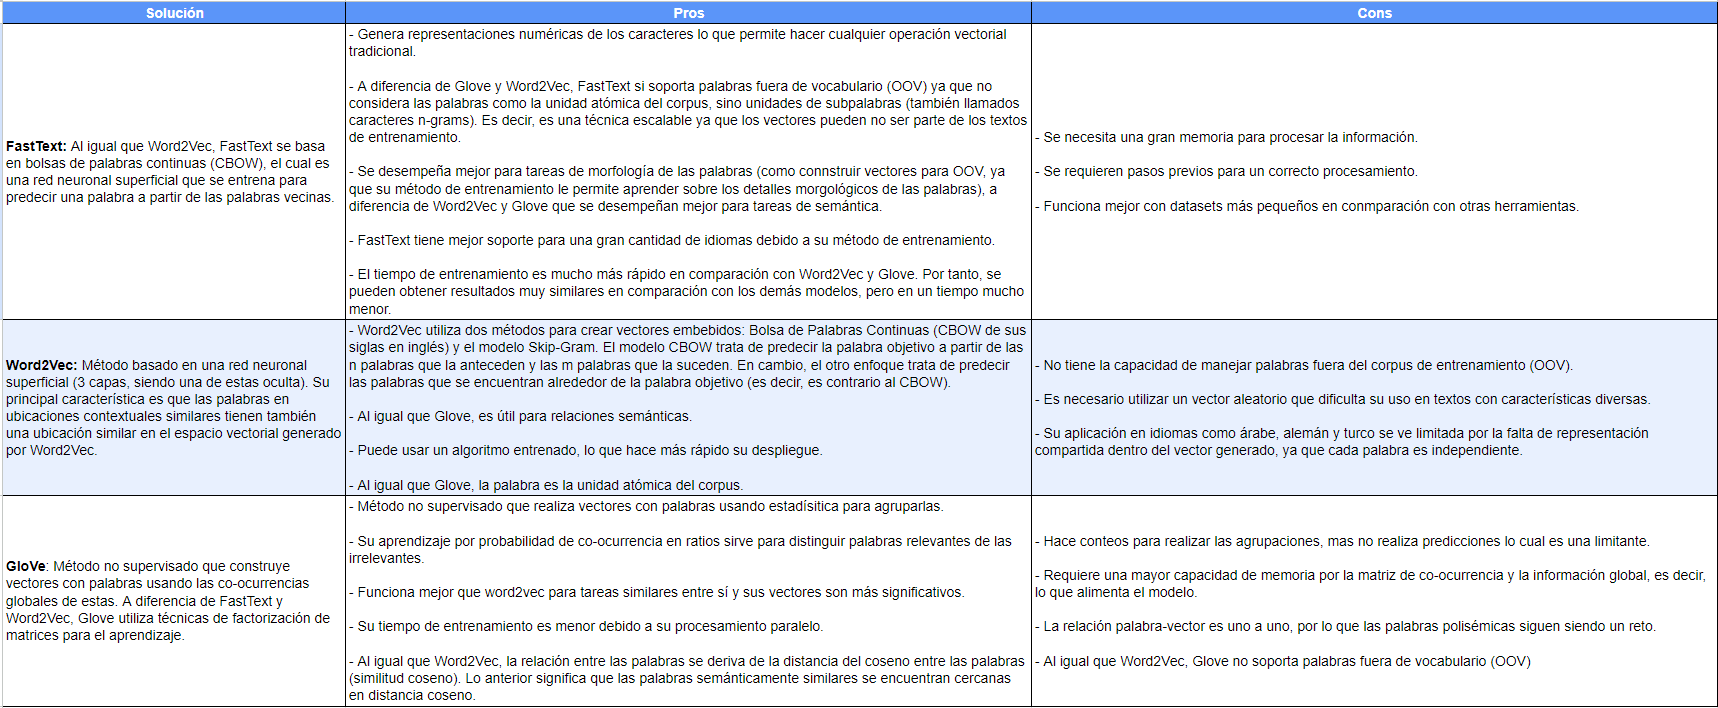

###6. Utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300. Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.

    https://fasttext.cc/docs/en/crawl-vectors.html

    NOTA: Debido a la cantidad de recursos computacionales que demanda cargar los vectores FastText (son 2 millones de vectores), es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo (pickle, npz o el que consideres más adecuado). Una vez realizado lo anterior, puedes borrar la variable de FastText para liberar memoria RAM. De esta manera, ya tienes tu vocabulario de vectores embebidos de acuerdo a los tokens que consideras más adecuados para tu problema y puedes usarlo rápidamente cuando lo necesites. En dado caso apóyense entre los miembros del equipo de tener dificultades para generar el vocabulario y por mientras puedes usar el archivo del vocabulario que alguno haya generado

In [ ]:
fast_text_voca = {}

for w in range(len(mivocab)):
  fast_text_voca[mivocab[w]] = ft.get_word_vector(mivocab[w]) #Variable donde se almacena el vocabulario generado por FastText.
## Guardar diccionario en un archivo npy.
np.save('fast_text_voca.npy', fast_text_voca)

In [ ]:
# Quitar comentarios si se desea cargar el diccionario creado con los 300 vectores embebidos.

import numpy as np
##Lectura del archivo npy. 
#fast_text_voca = np.load('fast_text_voca.npy', allow_pickle='TRUE')
#fast_text_voca=fast_text_voca.item()  # Se convierte la variable de numpy array a diccionario.
print("Cantidad de tokens:",len(fast_text_voca))
print("Cantidad de vectores embebidos pre-entrenados de la palabra 'much':",len(fast_text_voca.get('much')))

Cantidad de tokens: 1438
Cantidad de vectores embebidos pre-entrenados de la palabra 'much': 300


## 7. Una manera de utilizar los vectores embebidos con modelos de aprendizaje automático en documentos de texto, es asignar a cada comentario filtrado el vector embebido de dimensión 300 que resulta de promediar todos sus tokens. Así, en este ejercicio deberás generar los arreglos correspondientes para los conjuntos de entrenamiento, validación y prueba. Los llamaremos trainEmb, valEmb y testEmb, respectivamente. ¿Cuáles son sus dimensiones? ¿Se podrían usar para su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf? Responde a dichas preguntas.

In [ ]:
trainEmb = []
for ss in train_x:
  embeddings=[] 
  for w in ss:
    embeddings.append(fast_text_voca[w])
  trainEmb.append(np.mean(embeddings, axis=0)) # se saca el promedio de cada comentario
trainEmb=np.array(trainEmb)# Se convierte a una matriz

valEmb = []
for ss in val_x:
  embeddings=[] 
  for w in ss:
    embeddings.append(fast_text_voca[w])
  valEmb.append(np.mean(embeddings, axis=0)) # se saca el promedio de cada comentario
valEmb=np.array(valEmb)# Se convierte a una matriz

testEmb = []
for ss in test_x:
  embeddings=[] 
  for w in ss:
    embeddings.append(fast_text_voca[w])
  testEmb.append(np.mean(embeddings, axis=0)) # se saca el promedio de cada comentario
testEmb=np.array(testEmb)# Se convierte a una matriz


print("Dimensiones el conjunto de entrenamiento:",trainEmb.shape)
print("Dimensiones el conjunto de validación:",valEmb.shape)
print("Dimensiones el conjunto de prueba:",testEmb.shape)

Dimensiones el conjunto de entrenamiento: (2094, 300)
Dimensiones el conjunto de validación: (449, 300)
Dimensiones el conjunto de prueba: (444, 300)


<font color='blue'> **Justificación:**<font> 

¿Cuáles son sus dimensiones?

Las dimensiones son el número de comentarios asignado a cada conjunto por el número de vectores promediados (300). 

Dimensiones el conjunto de entrenamiento: (2094, 300)

Dimensiones el conjunto de validación: (449, 300)

Dimensiones el conjunto de prueba: (444, 300)

<font color='blue'> **Justificación:**<font> 

¿Se podrían usar para su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?

Esta pregunta podría responderse de dos maneras, dependiendo del enfoque que se le esté dando. Si la pregunta se refiere a utilizar matrices dispersas para representar los vectores embebidos, entonces la respuesta es no ya que son técnicas con propósitos diferentes. Además, las matrices dispersas tienen el problema de la "Maldición de la Dimensionalidad", ya que al crecer en dimensión su cómputo es más costoso.

Por otro lado, si la pregunta es con relación a combinar los vectores embebidos con matrices dispersas, como tf-tdf, entonces la respuesta es sí. Una manera de hacerlo es obteniendo los pesos de cada palabra o token y multiplicarlo por el vector embebido correspondiente a la palabra. De esta forma, el resultado final sería la representación del texto en un vector embebido que considera el peso de la palabra en el corpus.

## 8. Utiliza los modelos de regresión lineal y bosque aleatorio (random forest) y encuentra sus desempeños (accuracy). Compara los resultados con los de la semana anterior.

<font color='blue'> **Resultados usando los vectores embebidos "fastText"**

**Nota:** Resultados usando los mejores hyperparametros.

In [ ]:

LR_model_emb = LogisticRegression(C=0.7613, penalty='l2', solver= 'liblinear',max_iter=1000)
LR_model_emb.fit(trainEmb,y_train)


RF_model_emb= RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=78,min_samples_leaf=1,max_features='log2',n_jobs=-1,max_samples=98,random_state=10)
RF_model_emb.fit(trainEmb,y_train)

print('Resultados usando los vectores embebidos "fastText"')
print('\nLR_emb: Train-accuracy: %.2f%%' % (100*LR_model_emb.score(trainEmb, y_train)))
print('LR_emb: Val-accuracy: %2.f%%' % (100*LR_model_emb.score(valEmb, y_val)))

print('\nRF_emb: Train-accuracy: %.2f%%' % (100*RF_model_emb.score(trainEmb, y_train)))
print('RF_emb: Val-accuracy: %.2f%%' % (100*RF_model_emb.score(valEmb, y_val)))

Resultados usando los vectores embebidos "fastText"

LR_emb: Train-accuracy: 83.29%
LR_emb: Val-accuracy: 82%

RF_emb: Train-accuracy: 73.11%
RF_emb: Val-accuracy: 73.05%


<font color='blue'> **Resultados usando los procesos de limpieza de este programa para matrices de conteo y matrices tf-idf:**<font>

<font color='blue'> **Justificación:**<font>

Debido a que los resultados de la actividad Semanas 03 y 04 "Pre-procesamiento, Matrices Documento-Término (DTM) y TF-IDF mostraron un sobre entrenamiento, en esta actividad se asignaron matrices de conteo y matrices tfidf de forma similar que la actividad pasada  en el ejercicio 4 y se decidió calcular los valores para los modelos de aprendizaje automático random forest y regresión logística usando las matrices de conteo y las matrices tfidf para poderlas comparar con los resultados de los los vectores embebidos **fastText**. 

In [ ]:
# Dimensiones de los conjuntos de las matrices de conteo y matrices tfidf
print("Matrices de conteo:\n")
print("Dimensiones el conjunto de entrenamiento:",train_x_count.shape)
print("Dimensiones el conjunto de validación:",val_x_count.shape)
print("Dimensiones el conjunto de prueba:",test_x_count.shape)

print("\n Matrices de tfidf:\n")
print("Dimensiones el conjunto de entrenamiento:",train_x_tfidf.shape)
print("Dimensiones el conjunto de validación:",val_x_tfidf.shape)
print("Dimensiones el conjunto de prueba:",test_x_tfidf.shape)

Matrices de conteo:

Dimensiones el conjunto de entrenamiento: (2094, 1438)
Dimensiones el conjunto de validación: (449, 1438)
Dimensiones el conjunto de prueba: (444, 1438)

 Matrices de tfidf:

Dimensiones el conjunto de entrenamiento: (2094, 1438)
Dimensiones el conjunto de validación: (449, 1438)
Dimensiones el conjunto de prueba: (444, 1438)


<font color='blue'> **Observación:**<font>

Tanto para las matrices de conteo como para las matrices tfidf, las dimensiones son el número  de comentarios asignados a cada conjunto x el tamaño del vocabulario (1438).

In [ ]:
# Matrices de conteo
LR_model_count=LogisticRegression(C=0.0017765, class_weight= None , penalty='l2', solver= 'lbfgs',max_iter=1000000)
LR_model_count.fit(train_x_count,y_train)
RF_model_count = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='sqrt',n_jobs=-1,max_samples=0.0666,random_state=10)
RF_model_count.fit(train_x_count,y_train)

#Matrices tf-idf:
LR_model_tfidf=LogisticRegression(C=0.4, class_weight= None , penalty='l1', solver= 'liblinear',max_iter=100)
LR_model_tfidf.fit(train_x_tfidf,y_train)
RF_model_tfidf = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='sqrt',n_jobs=-1,max_samples=0.0666,random_state=10)
RF_model_tfidf.fit(train_x_tfidf,y_train)

print('\nResultados usando matrices de conteo')
print('\nLR_count: Train-accuracy: %.2f%%' % (100*LR_model_count.score(train_x_count, y_train)))
print('LR_count: Val-accuracy: %2.f%%' % (100*LR_model_count.score(val_x_count, y_val)))
print('\nRF_count: Train-accuracy: %.2f%%' % (100*RF_model_count.score(train_x_count, y_train)))
print('RF_count: Val-accuracy: %.2f%%' % (100*RF_model_count.score(val_x_count, y_val)))

print('\n\nResultados usando matrices tfidf')
print('\nLR_tfidf: Train-accuracy: %.2f%%' % (100*LR_model_tfidf.score(train_x_tfidf, y_train)))
print('LR_tfidf: Val-accuracy: %2.f%%' % (100*LR_model_tfidf.score(val_x_tfidf, y_val)))
print('\nRF_tfidf: Train-accuracy: %.2f%%' % (100*RF_model_tfidf.score(train_x_tfidf, y_train)))
print('RF_tfidf: Val-accuracy: %.2f%%' % (100*RF_model_tfidf.score(val_x_tfidf, y_val)))



Resultados usando matrices de conteo

LR_count: Train-accuracy: 73.64%
LR_count: Val-accuracy: 72%

RF_count: Train-accuracy: 69.01%
RF_count: Val-accuracy: 68.60%


Resultados usando matrices tfidf

LR_tfidf: Train-accuracy: 77.03%
LR_tfidf: Val-accuracy: 76%

RF_tfidf: Train-accuracy: 71.35%
RF_tfidf: Val-accuracy: 69.71%


<font color='blue'> **Justificación:**<font>

*Compara los resultados con los de la semana anterior.*

Comparando los resultados usando los vectores embebidos **fastText** contra los resultados de la semana anterior y eliminando el sobre entrenamiento con los mejores hyperparametros para cada caso se observa que usando los vectores embebidos **fastTest** muestra un mejor acurracy en entrenamiento y en validación tanto en Regresión Logística (RL) y Random Forest (RF) que usando **matrices de conteo** o **matrices tfidf**.  A continuación, se ve en verde el mejor modelo y en rojo el peor modelo.

<font color='green'>**Resultados usando los vectores embebidos "fastText"**

<font color='green'>LR_emb: Train-accuracy: 83.29%

<font color='green'>LR_emb: Val-accuracy: 82%

<font color='green'>RF_emb: Train-accuracy: 73.11%

<font color='green'>RF_emb: Val-accuracy: 73.05%

<font color='orange'>**Resultados usando matrices tfidf** (Semana anterior)

<font color='orange'>LR_tfidf: Train-accuracy: 77.03%

<font color='orange'>LR_tfidf: Val-accuracy: 76%

<font color='orange'>RF_tfidf: Train-accuracy: 71.35%

<font color='orange'>RF_tfidf: Val-accuracy: 69.71%


<font color='red'>**Resultados usando matrices de conteo** (Semana anterior)

<font color='red'>LR_count: Train-accuracy: 73.64%

<font color='red'>LR_count: Val-accuracy: 72%

<font color='red'> RF_count: Train-accuracy: 69.01%

<font color='red'>RF_count: Val-accuracy: 68.60%





## 9. Obtener la matriz de confusión e interpretar sus valores.

Matriz de confusión para Regresión Logística (RL) usando los vectores embebidos fastText
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       208
           1       0.83      0.86      0.84       236

    accuracy                           0.83       444
   macro avg       0.83      0.83      0.83       444
weighted avg       0.83      0.83      0.83       444



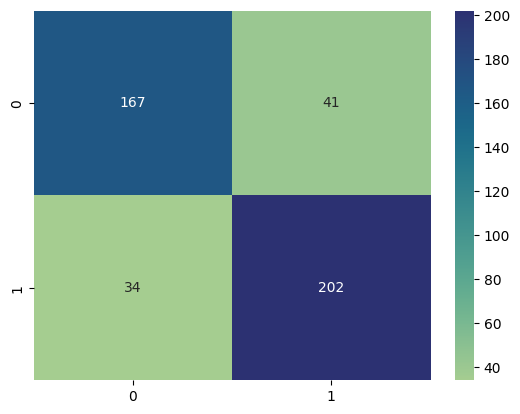

In [ ]:
y_pred_LR = LR_model_emb.predict(testEmb)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión para Regresión Logística (RL) usando los vectores embebidos fastText")
print(classification_report(y_test,y_pred_LR))

Matriz de confusión para Random Forest (RF) cusando los vectores embebidos fastText
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       208
           1       0.72      0.75      0.73       236

    accuracy                           0.71       444
   macro avg       0.71      0.71      0.71       444
weighted avg       0.71      0.71      0.71       444



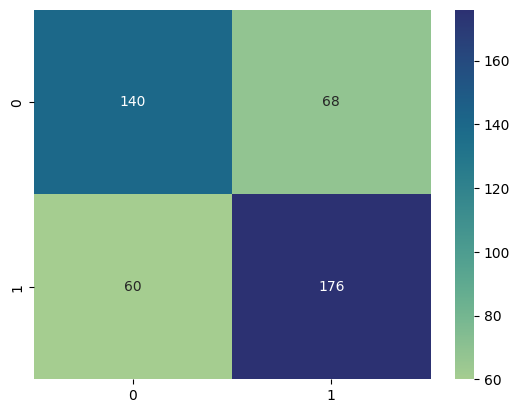

In [ ]:
y_pred_RF = RF_model_emb.predict(testEmb)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión para Random Forest (RF) cusando los vectores embebidos fastText")
print(classification_report(y_test,y_pred_RF))

### <font color='blue'> **Interpretación de valores**<font>

La Matriz de confusión para Regresión Logística (RL) usando los vectores embebidos fastText muestra mejores resultados que la Matriz de confusión para Random Forest (RF) usando los vectores embebidos fastText comparando sus métricas:
* precision
* recall
* f1-score.

Genera menos falsos positivos y menos falsos negativos el modelo de Regresión Logística (RL) en comparación al modelo de Random Forest (RF).

## 10. Comenta con tus compañeros de equipo los pasos realizados en esta actividad e incluyan sus conclusiones finales.

### <font color='blue'> **Conclusiones:**<font>

De acuerdo con el contenido del curso, el objetivo de esta actividad es contrastar los conceptos que llevan a la análisis de un texto; ilustrar las características principales de un texto; producir modelos de vectores de palabras (vectores embebidos) y examinar los documentos mediante estas técnicas. Y para lograrlo iniciamos con el modelo pre-entrenado FastText, para después cargar los datos y realizar una limpieza de los mismos. Enseguida, hicimos una partición de los datos para tener conjuntos de entrenamiento, validación y prueba. 

Una vez que los pasos anteriores se concluyeron, comenzamos a utilizar los vectores embebidos FastText preentrenados por Facebook. Cabe mencionar que fue muy enriquecedor realizar una comparativa de FastText con Word2Vec y Glove, ya que nos permitió entender los puntos positivos y negativos de cada una de estas. Posteriormente, y una vez que se concluyó el porceso con la herramienta FastText, aplicamos el modelo de regresión lineal y bosque aleatorio, cuyos resultados fueron comparados con los de la semana pasada. 

Es importante resaltar que el resultado de la regresión logística tiene mayor accuracy esta semana con 83.29% para entrenamiento y 82% de prueba (dif. 1.29%), mientras que la semana pasada para las matrices TF-IDF se obtuvo 77.03% y 76%, respectivamente (dif. 1.03). En cuanto a la matriz de conteo, en este mismo modelo, también se aprecia una diferencia importante ya que se había obtenido 73.64% en entrenamiento y 72% en prueba (dif. 1.64). Por otro lado, los resultados del bosque aleatorio también arrojaron resultados con un mejor accuracy esta semana con 73.11% para entrenamiento y 73.05% para prueba (dif. 0.06%). Sin embargo, la semana pasada se había obtenido en matrices TF-IDF entrenamiento con 71.35% y prueba con 69.71% (dif. 1.61%); mientras que en las matrices de conteo los resultados fueron de 69.01% y 68.6%, respectivamente (dif. 0.41%). 

Por tanto, podemos concluir que, en cuanto a la comparación contra la semana pasada, nuestros modelos tuvieron un mejor accuracy y, también, logramos controlar el sobreentrenamiento en ambos casos. En los resultados de esta semana, las matrices de conteo y de TF-IDF para ambos modelos tuvieron menor accuracy que los resultados de los vectores embebidos "FastText", por lo que se podría concluir que la implementación de este último realmente tuvo un impacto positivo en el rendimiento del modelo. 

### **Referencias:**
* Alpha Quantum. (s.f.) Introduction to word embeddings – Word2Vec, Glove, FastText and ELMo. https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/

* Analytics Vidhya. (2020). Text Classification & Word Representations using FastText (An NLP library by Facebook). NSS. https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/

* Aylien. (s.f.). Word Embeddings and Their Challenges. A Quantexa Company. https://aylien.com/blog/word-embeddings-and-their-challenges

* Badri, N., Kboubi, F., Habacha, A. (2022). Combining Fast Text and Glove Word Embedding for Offensive and Hate speech Text Detection. ScienceDirect. https://www.sciencedirect.com/?ref=pdf_download&fr=RR-11&rr=7cb274b438ecb6e8

* Chandran, S. (2020). Introduction to Text Representations for Language Processing — Part 2. Towards Data Science. https://towardsdatascience.com/introduction-to-text-representations-for-language-processing-part-2-54fe6907868

* Facebook. (2022). Get started. https://fasttext.cc/docs/en/support.html

* Introduction to word embeddings – word2vec, glove, FastText and Elmo. Data Science Machine Learning Deep Learning. (n.d.). https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/ 

* Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). Bag of tricks for efficient text classification. arXiv preprint arXiv:1607.01759.

* KeepCoding. (s.f.). ¿Qué son los algoritmos word embedding?. https://keepcoding.io/blog/que-son-los-algoritmos-word-embedding/

* KeepCoding. (s.f.). ¿Qué es FastText y cómo funciona?. https://keepcoding.io/blog/que-es-fasttext-y-como-funciona/

* Lang, N. (2022). Stemming vs. Lemmatization in NLP. Towards data science. https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0

* Malafosse, C. (2021, November 15). FastText sentiment analysis for tweets: A straightforward guide. Medium. https://towardsdatascience.com/fasttext-sentiment-analysis-for-tweets-a-straightforward-guide-9a8c070449a2 

* Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

* Pennington, Jeffrey & Socher, Richard & Manning, Christopher. (2014). Glove: Global Vectors for Word Representation. EMNLP. 14. 1532-1543. 10.3115/v1/D14-1162. 

* Scikit-learn (s.f.).sklearn.ensemble.RandomForestClassifier. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* Scikit-learn (s.f.).sklearn.linear_model.LogisticRegression. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

* Taylor, J. (2018, December 31). Supercharging word vectors. Medium. https://towardsdatascience.com/supercharging-word-vectors-be80ee5513d 

* Vij, Y. (2019, September 25). Combining word embeddings to form document embeddings. Medium. https://medium.com/analytics-vidhya/combining-word-embeddings-to-form-document-embeddings-9135a66ae0f 